## Step 1: Data Preparation

### 1.1 Cleaning and Structuring Data


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the data
df = pd.read_csv('HIV data 2000-2023.csv',encoding='latin1')

In [4]:
# Extract numeric value from the 'Value' column (handling the range format)
df['NumericValue'] = df['Value'].str.extract(r'(\d+\s?\d+)')[0].str.replace(' ', '').astype(float)


In [5]:
# Convert Period to datetime
df['Year'] = pd.to_datetime(df['Period'], format='%Y').dt.year

### 1.2 Calculating Global Totals


In [6]:
# Calculate global totals per year
global_totals = df.groupby('Year')['NumericValue'].sum().reset_index()
global_totals.rename(columns={'NumericValue': 'GlobalTotal'}, inplace=True)

## Step 2: Identifying Top Countries Contributing to 75% Global Burden

### 2.1 Calculating Cumulative Contribution


In [7]:
# Get most recent year's data (assuming 2023 is most complete)
latest_year = df[df['Year'] == 2023]

# Calculate country contributions
latest_year = latest_year.sort_values('NumericValue', ascending=False)
latest_year['CumulativePercentage'] = (latest_year['NumericValue'].cumsum() / 
                                     latest_year['NumericValue'].sum() * 100)

# Identify countries reaching 75% threshold
top_countries_global = latest_year[latest_year['CumulativePercentage'] <= 75]['Location'].unique()

### 2.2 Visualizing Global Trends


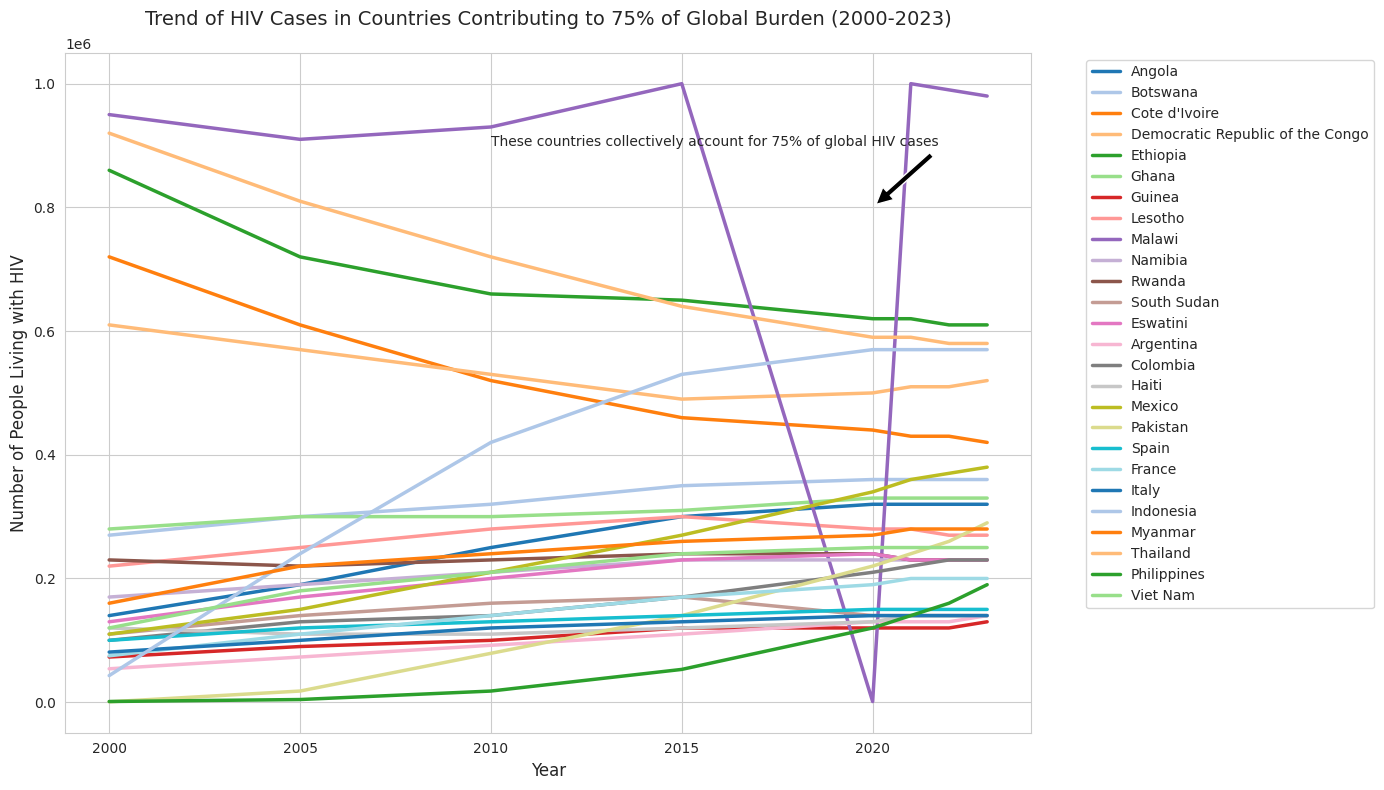

In [8]:
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Filter data for top countries
top_countries_data = df[df['Location'].isin(top_countries_global)]

# Plot
ax = sns.lineplot(data=top_countries_data, x='Year', y='NumericValue', 
                 hue='Location', palette='tab20', linewidth=2.5)

plt.title('Trend of HIV Cases in Countries Contributing to 75% of Global Burden (2000-2023)',
         fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of People Living with HIV', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add annotation for 75% threshold
plt.annotate('These countries collectively account for 75% of global HIV cases',
            xy=(2020, top_countries_data['NumericValue'].max()*0.8),
            xytext=(2010, top_countries_data['NumericValue'].max()*0.9),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=10)

plt.show()

## Step 3: Regional Analysis

### 3.1 Identifying Top Countries in Each Region


In [9]:
# Get list of WHO regions
regions = df['ParentLocation'].unique()

# Create dictionary to store top countries per region
regional_top_countries = {}

for region in regions:
    region_data = latest_year[latest_year['ParentLocation'] == region].sort_values('NumericValue', ascending=False)
    region_data['CumulativePercentage'] = (region_data['NumericValue'].cumsum() / 
                                         region_data['NumericValue'].sum() * 100)
    regional_top_countries[region] = region_data[region_data['CumulativePercentage'] <= 75]['Location'].unique()

### 3.2 Visualizing Regional Trends


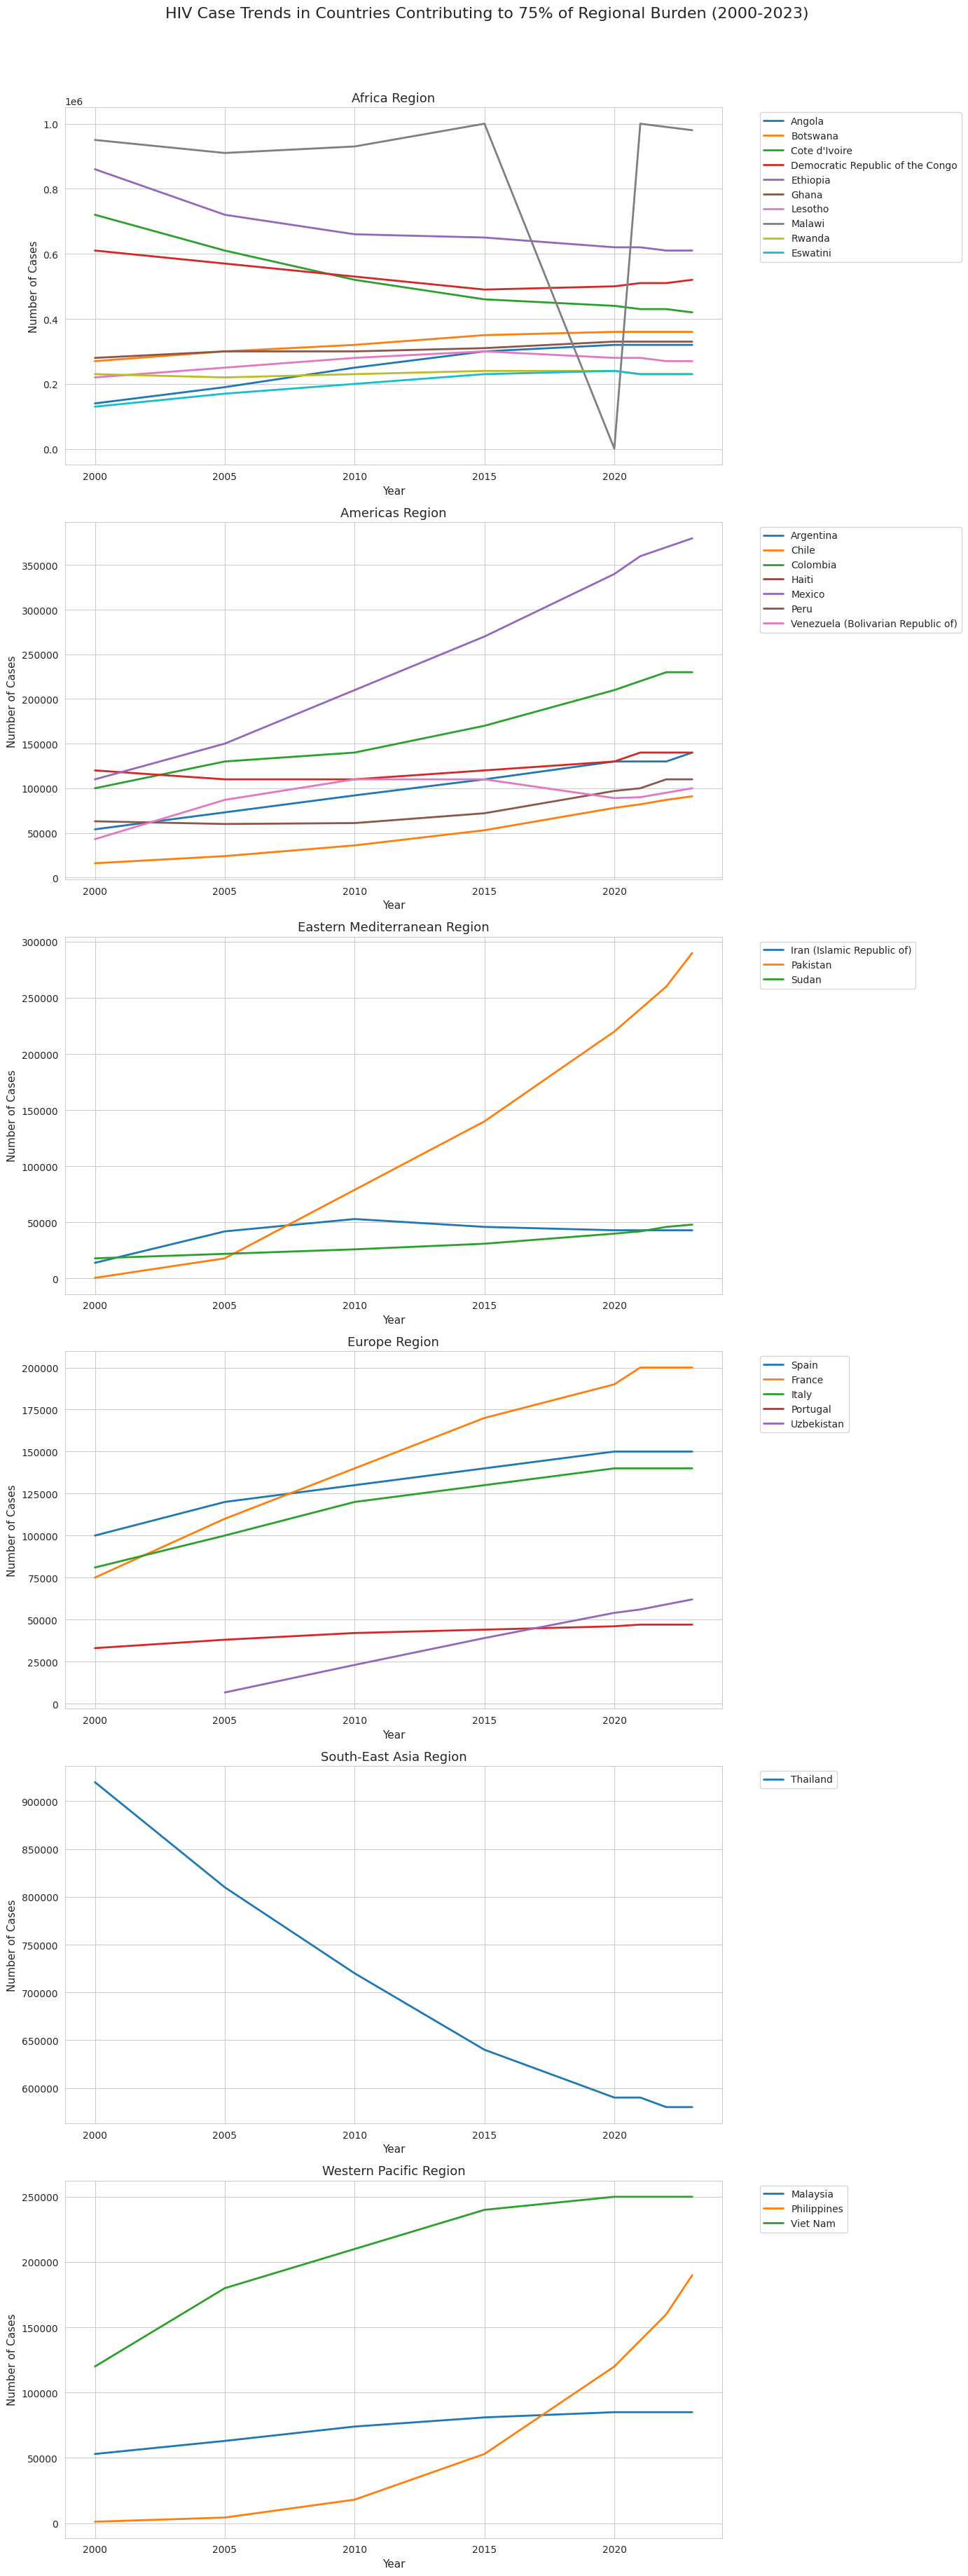

In [10]:
# Create a grid of plots for each region
fig, axes = plt.subplots(len(regions), 1, figsize=(14, 6*len(regions)))
fig.suptitle('HIV Case Trends in Countries Contributing to 75% of Regional Burden (2000-2023)',
            fontsize=16, y=1.02)

for i, region in enumerate(regions):
    # Filter data for region's top countries
    region_countries = regional_top_countries[region]
    region_data = df[(df['ParentLocation'] == region) & 
                    (df['Location'].isin(region_countries))]
    
    # Plot
    sns.lineplot(data=region_data, x='Year', y='NumericValue', 
                hue='Location', ax=axes[i], palette='tab10', linewidth=2)
    
    axes[i].set_title(f'{region} Region', fontsize=13)
    axes[i].set_xlabel('Year', fontsize=11)
    axes[i].set_ylabel('Number of Cases', fontsize=11)
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 4: Enhanced Visualization

### 4.1 Small Multiples with Content


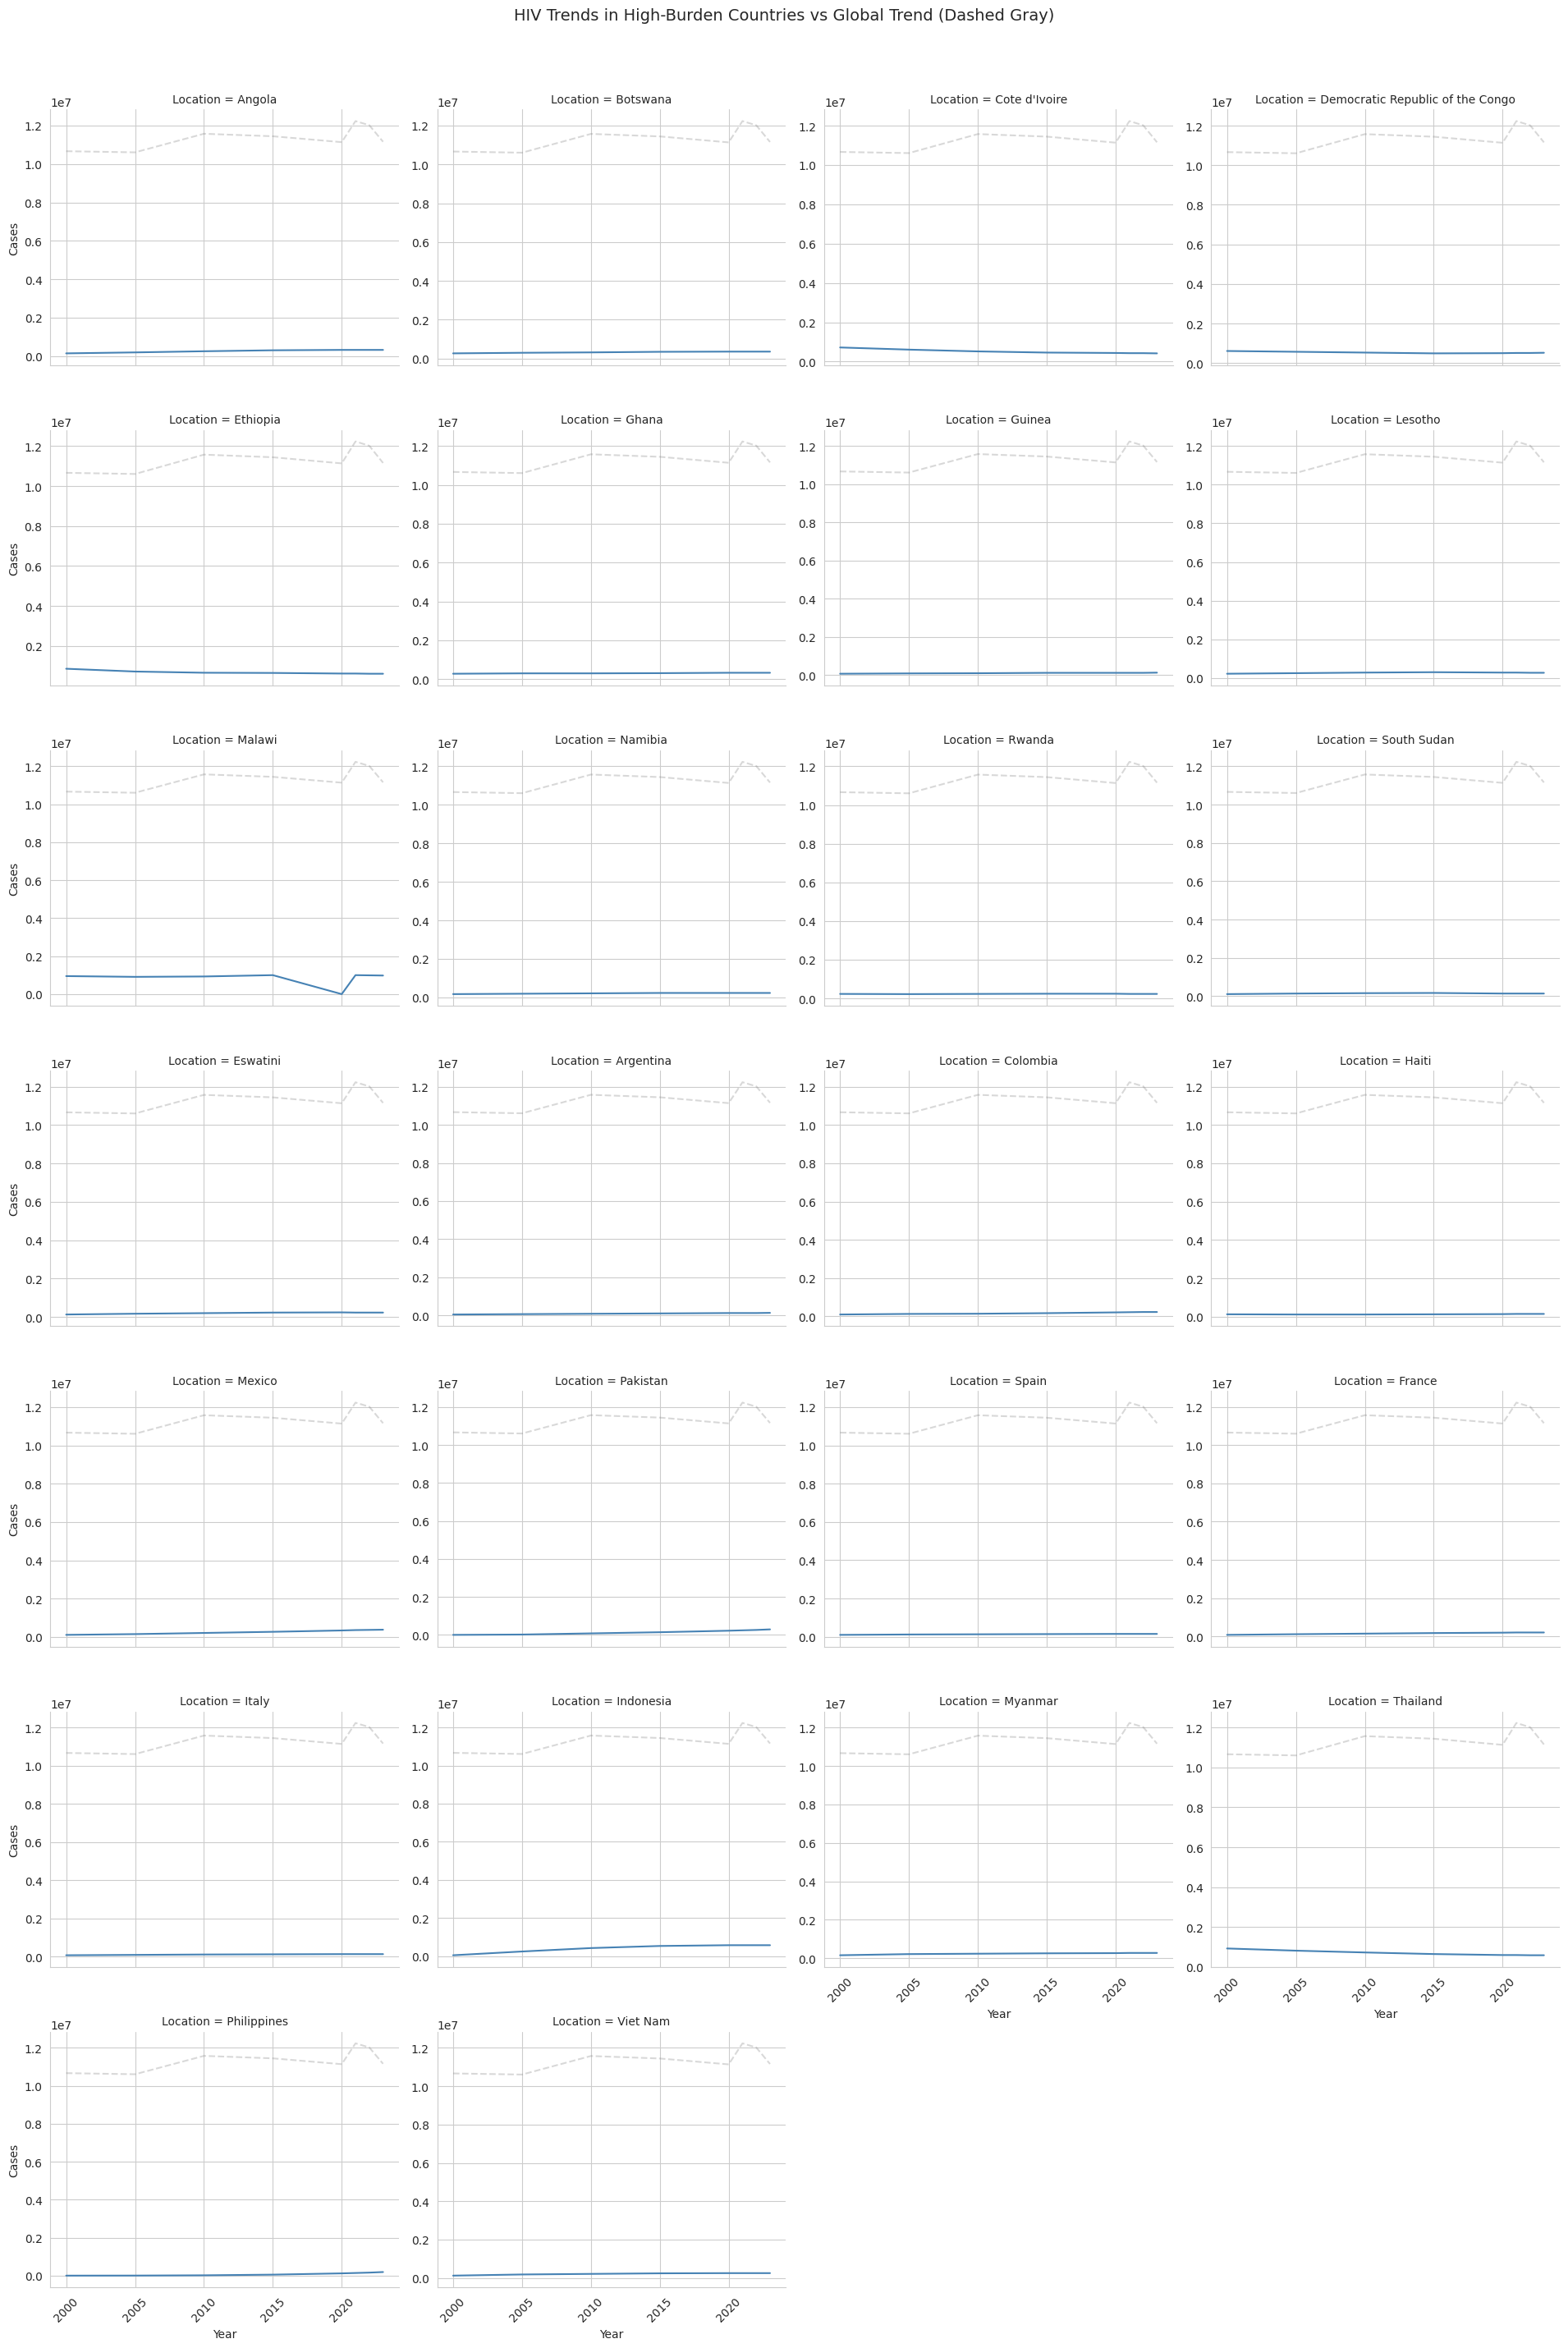

In [11]:
# Create small multiples plot with shared y-axis
g = sns.FacetGrid(data=top_countries_data, col='Location', 
                  col_wrap=4, height=4, aspect=1.2, sharey=False)
g.map(sns.lineplot, 'Year', 'NumericValue', color='steelblue')

# Add global trend as reference in background
for ax in g.axes.flat:
    sns.lineplot(data=global_totals, x='Year', y='GlobalTotal', 
                ax=ax, color='gray', alpha=0.3, linestyle='--')
    ax.set_title(ax.get_title(), fontsize=10)
    ax.tick_params(axis='x', rotation=45)

g.fig.suptitle('HIV Trends in High-Burden Countries vs Global Trend (Dashed Gray)', 
              y=1.02, fontsize=14)
g.set_axis_labels('Year', 'Cases')
plt.tight_layout()
plt.show()

### 4.2 Interactive Visualization


In [13]:
import plotly.express as px

fig = px.line(top_countries_data, x='Year', y='NumericValue',
              color='Location', line_shape='spline',
              title='Interactive View of HIV Trends in High-Burden Countries',
              labels={'NumericValue': 'Number of Cases'},
              hover_data=['ParentLocation'])

fig.update_layout(hovermode='x unified')
fig.show()

## Multidimensional Poverty & HIV: An Integrated Analysis

### Step 1: Data Preprocessing & Merging

### 1.1 Cleaning World Bank Poverty Data


In [16]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [17]:
wbdf=pd.read_excel('multidimensional_poverty.xlsx',header=1)

In [18]:
wbdf.head()

,Region,Country code,Economy,Reporting year,Survey name,Survey year,Survey coverage,Welfare type,Survey comparability,Deprivation rate (share of population),Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Multidimensional poverty headcount ratio (%)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monetary (%),Educational attainment (%),Educational enrollment (%),Electricity (%),Sanitation (%),Drinking water (%),NaN
1,SSA,AGO,Angola,2018.0,IDREA,2018.0,N,c,2.0,31.122005,29.753423,27.44306,52.639532,53.637516,32.106507,47.203606
2,ECA,ALB,Albania,2012.0,HBS,2018.0,N,c,1.0,0.048107,0.19238,-,0.06025,6.579772,9.594966,0.293161
3,LAC,ARG,Argentina,2010.0,EPHC-S2,2021.0,U,i,3.0,0.894218,1.08532,0.731351,0,0.257453,0.364048,0.906573
4,ECA,ARM,Armenia,2010.0,ILCS,2021.0,N,c,1.0,0.523521,0,1.793004,0,0.397725,0.660082,0.523521


In [19]:
wbdf.shape

(111, 16)

## Step 2: Sectioning World Bank Poverty Data and Concatenating


In [20]:
section1= wbdf.iloc[:,0:10]
section1 = section1.drop(index=0)
section1.head()

,Region,Country code,Economy,Reporting year,Survey name,Survey year,Survey coverage,Welfare type,Survey comparability,Deprivation rate (share of population)
1,SSA,AGO,Angola,2018.0,IDREA,2018.0,N,c,2.0,31.122005
2,ECA,ALB,Albania,2012.0,HBS,2018.0,N,c,1.0,0.048107
3,LAC,ARG,Argentina,2010.0,EPHC-S2,2021.0,U,i,3.0,0.894218
4,ECA,ARM,Armenia,2010.0,ILCS,2021.0,N,c,1.0,0.523521
5,EAP,AUS,Australia,2010.0,SIH-LIS,2018.0,N,I,3.0,0.51688


In [21]:
section2=wbdf.iloc[0:,10:15]
section2.columns = section2.iloc[0]
section2 = section2[1:]  
section2.head()

,Educational attainment (%),Educational enrollment (%),Electricity (%),Sanitation (%),Drinking water (%)
1,29.753423,27.44306,52.639532,53.637516,32.106507
2,0.19238,-,0.06025,6.579772,9.594966
3,1.08532,0.731351,0,0.257453,0.364048
4,0,1.793004,0,0.397725,0.660082
5,1.71188,-,0,0,-


In [22]:
section3=wbdf.iloc[:,15]
section3 = section3.drop(index=0)
section3

1      47.203606
2       0.293161
3       0.906573
4       0.523521
5       2.215770
         ...    
106     2.253092
107     1.266184
108    19.892171
109    66.506058
110    42.397931
Name: Multidimensional poverty headcount ratio (%), Length: 110, dtype: float64

In [23]:
# concatinating sections to a new df
new_wbdf = pd.concat([section1, section2,section3], axis=1)

In [24]:
new_wbdf.head(3)

,Region,Country code,Economy,Reporting year,Survey name,Survey year,Survey coverage,Welfare type,Survey comparability,Deprivation rate (share of population),Educational attainment (%),Educational enrollment (%),Electricity (%),Sanitation (%),Drinking water (%),Multidimensional poverty headcount ratio (%)
1,SSA,AGO,Angola,2018.0,IDREA,2018.0,N,c,2.0,31.122005,29.753423,27.44306,52.639532,53.637516,32.106507,47.203606
2,ECA,ALB,Albania,2012.0,HBS,2018.0,N,c,1.0,0.048107,0.19238,-,0.06025,6.579772,9.594966,0.293161
3,LAC,ARG,Argentina,2010.0,EPHC-S2,2021.0,U,i,3.0,0.894218,1.08532,0.731351,0,0.257453,0.364048,0.906573


In [26]:
# Clean deprivation rates (convert % strings to floats)
def clean_percentage(x):
    if isinstance(x, str):
        if x.strip() == '-':  # Handle missing or non-applicable values
            return np.nan  # Or return 0.0 if you prefer
        return float(x.replace('%', '').strip()) / 100
    return x

wbdf2 = new_wbdf.copy()
poverty_metrics = [
    'Deprivation rate (share of population)',
    'Educational attainment (%)',
    'Educational enrollment (%)',
    'Electricity (%)',
    'Sanitation (%)',
    'Drinking water (%)'
]

for col in poverty_metrics:
    wbdf2[col] = wbdf2[col].apply(clean_percentage)

# Standardize country names for merging
wbdf2['Country'] = wbdf2['Economy'].str.replace('St. ', 'Saint ')  # e.g., "St. Lucia" → "Saint Lucia"

### 1.2 Cleaning & Merging HIV Data


In [27]:
# Extract numeric HIV values (as before)
hiv_df = df.copy()
hiv_df['HIV_Cases'] = hiv_df['Value'].str.extract(r'(\d+\s?\d+)')[0].str.replace(' ', '').astype(float)

# Merge datasets on Country and Year
merged_df = pd.merge(
    hiv_df,
    wbdf2,
    left_on=['Location', 'Period'],
    right_on=['Country', 'Reporting year'],
    how='inner'
)

# Keep relevant columns
merged_df = merged_df[[
    'Location', 'ParentLocation', 'Period', 'HIV_Cases',
    'Multidimensional poverty headcount ratio (%)',
    'Deprivation rate (share of population)',
    'Educational attainment (%)',
    'Educational enrollment (%)',
    'Electricity (%)',
    'Sanitation (%)',
    'Drinking water (%)'
]]

In [30]:
merged_df.head()

,Location,ParentLocation,Period,HIV_Cases,Multidimensional poverty headcount ratio (%),Deprivation rate (share of population),Educational attainment (%),Educational enrollment (%),Electricity (%),Sanitation (%),Drinking water (%)
0,Benin,Africa,2015,71000.0,45.443240,12.723279,49.023893,31.661823,34.818304,76.649594,24.109130
1,Cote d'Ivoire,Africa,2015,460000.0,29.177094,9.733193,44.493997,24.717054,9.264950,59.909374,17.286547
2,Guinea-Bissau,Africa,2010,37000.0,38.730049,25.962856,20.071073,31.059781,27.570510,60.362864,20.897064
3,Kenya,Africa,2015,1500.0,38.490102,36.146057,10.055726,1.179968,24.500306,22.312516,36.060327
4,Malawi,Africa,2010,930000.0,78.252000,70.060599,54.329389,3.686354,88.757396,75.137657,11.400399


## Step 2: Exploratory Analysis & Visualization

### 2.1 Correlation Heatmap (HIV vs. Poverty Dimensions)


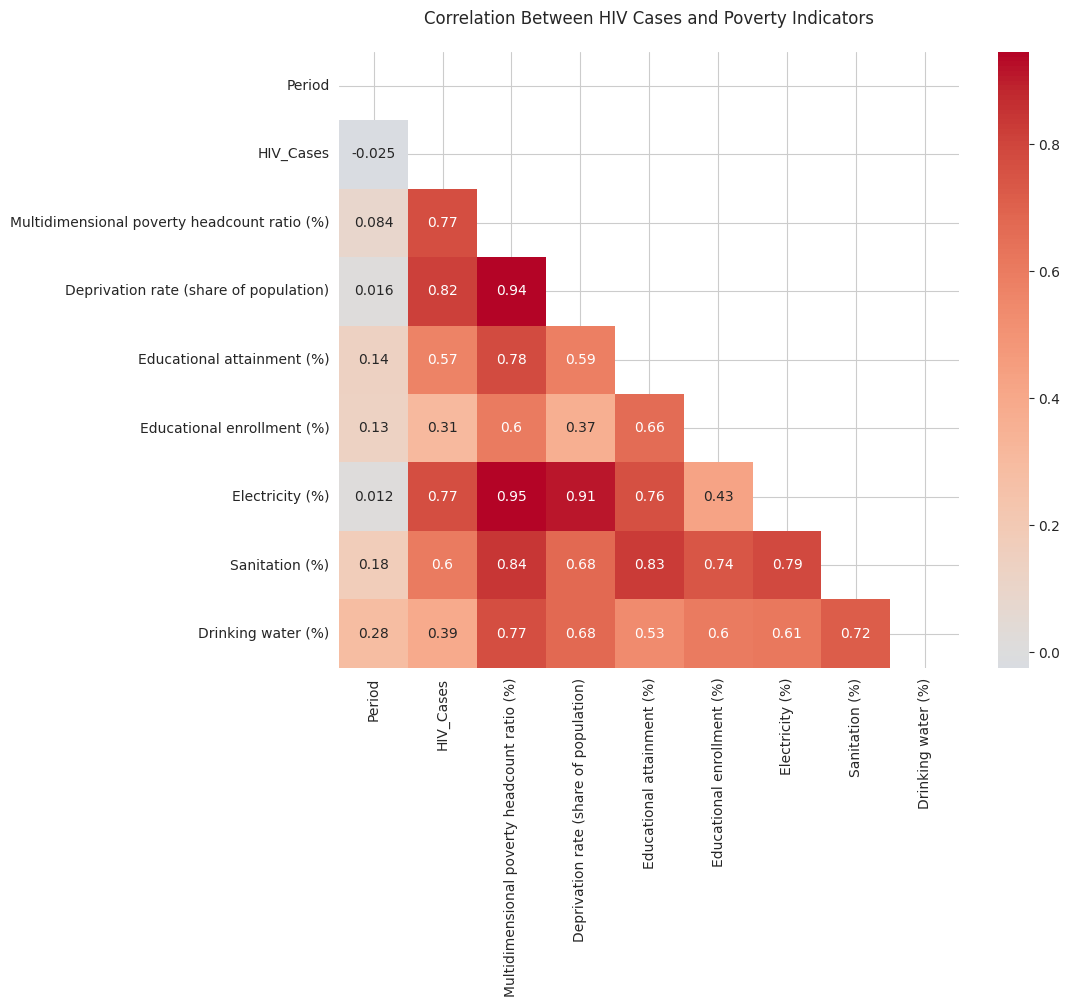

In [31]:
corr_matrix = merged_df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    mask=np.triu(np.ones_like(corr_matrix, dtype=bool))
)
plt.title("Correlation Between HIV Cases and Poverty Indicators", pad=20)
plt.show()

### 2.2 Scatter Plot Matrix (HIV vs. Key Poverty Indicators)


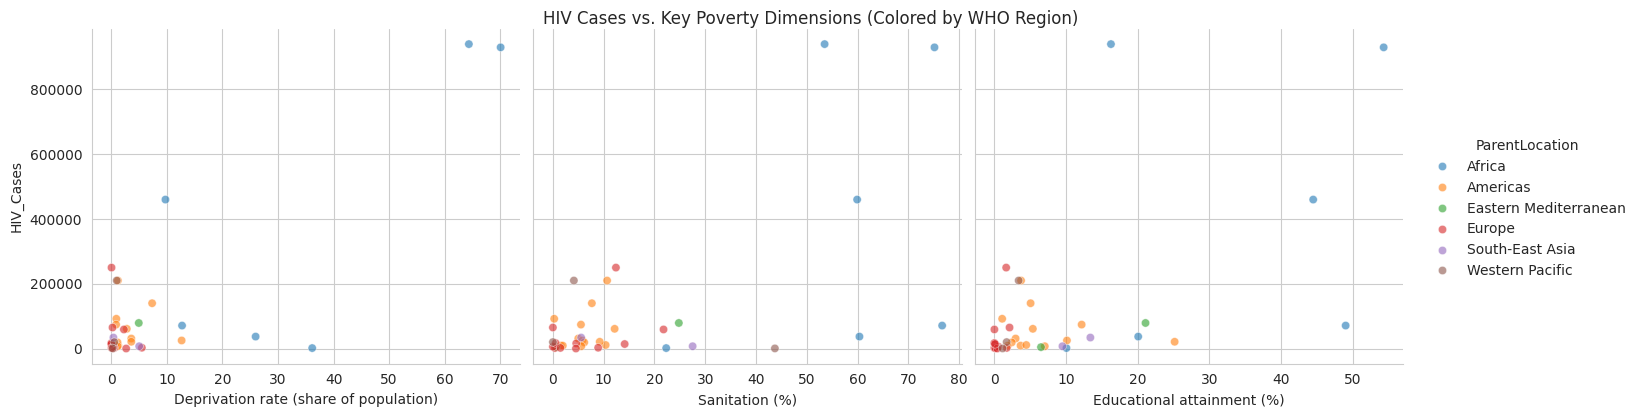

In [32]:
sns.pairplot(
    merged_df,
    x_vars=['Deprivation rate (share of population)', 'Sanitation (%)', 'Educational attainment (%)'],
    y_vars=['HIV_Cases'],
    hue='ParentLocation',
    height=4,
    aspect=1.2,
    plot_kws={'alpha': 0.6}
)
plt.suptitle("HIV Cases vs. Key Poverty Dimensions (Colored by WHO Region)", y=1.02)
plt.show()

## Step 3: Statistical Modeling (Accounting for Random Effects)

### 3.1 Mixed-Effects Regression Model


In [34]:
# Clean and rename columns
merged_df_clean = merged_df.dropna().rename(columns={
    'Multidimensional poverty headcount ratio (%)': 'poverty',
    'Sanitation (%)': 'sanitation',
    'Educational attainment (%)': 'education',
    'Electricity (%)': 'electricity'
})

# Run model
model = smf.mixedlm(
    "HIV_Cases ~ poverty + sanitation + education + electricity",
    data=merged_df_clean,
    groups=merged_df_clean['Location'],
    re_formula="~poverty"
).fit()
print(model.summary())

/home/comphortine/Comphortine/Dermatology Assistant/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/comphortine/Comphortine/Dermatology Assistant/venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning:

Retrying MixedLM optimization with lbfgs



                     Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       HIV_Cases      
No. Observations:       29            Method:                   REML           
No. Groups:             29            Scale:                    1006629359.3273
Min. group size:        1             Log-Likelihood:           -326.8026      
Max. group size:        1             Converged:                Yes            
Mean group size:        1.0                                                    
-------------------------------------------------------------------------------
                        Coef.       Std.Err.    z    P>|z|   [0.025     0.975] 
-------------------------------------------------------------------------------
Intercept                33561.603  21388.829  1.569 0.117  -8359.732 75482.938
poverty                   6738.484   6000.067  1.123 0.261  -5021.432 18498.399
sanitation                -535.314   1461.184 -0.366 0.714  -

/home/comphortine/Comphortine/Dermatology Assistant/venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



## Step 4: Advanced Visualization

### 4.1 Interactive Bubble Plot (HIV, Poverty, & Region)


In [35]:
import plotly.express as px

fig = px.scatter(
    merged_df,
    x="Multidimensional poverty headcount ratio (%)",
    y="HIV_Cases",
    size="Deprivation rate (share of population)",
    color="ParentLocation",
    hover_name="Location",
    animation_frame="Period",
    trendline="lowess",
    title="HIV Burden vs. Poverty Headcount (Size = Deprivation Rate)"
)
fig.update_layout(hovermode="closest")
fig.show()

### 4.2 Small Multiples by WHO Region


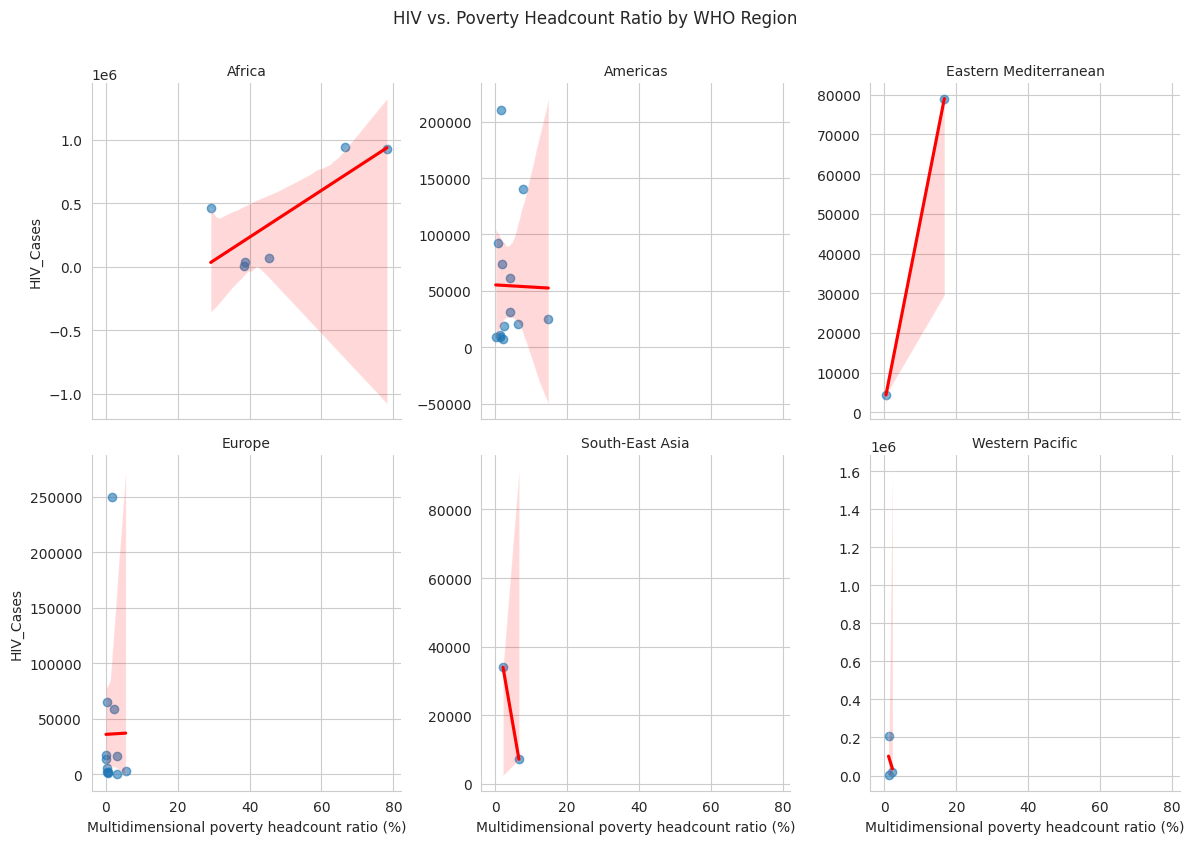

In [36]:
g = sns.FacetGrid(
    merged_df,
    col="ParentLocation",
    col_wrap=3,
    height=4,
    sharey=False
)
g.map(
    sns.regplot,
    "Multidimensional poverty headcount ratio (%)",
    "HIV_Cases",
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
)
g.set_titles("{col_name}")
g.fig.suptitle("HIV vs. Poverty Headcount Ratio by WHO Region", y=1.05)
plt.show()

## Step 5: Policy Recommendations (Derived from Findings)


# Question 2


## Child Mortality in East Africa: A Geospatial & Temporal Analysis

### Step 1: Data Preparation


In [37]:
neonatal_df=pd.read_csv('neonatal_mortality_rate.csv',encoding='latin1')

In [38]:
ufm_df = pd.read_csv('under_five mortality rate.csv')

In [39]:
neonatal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   REF_AREA                34 non-null     object 
 1   Geographic area         34 non-null     object 
 2   INDICATOR               34 non-null     object 
 3   Indicator               34 non-null     object 
 4   SEX                     34 non-null     object 
 5   Sex                     34 non-null     object 
 6   WEALTH_QUINTILE         34 non-null     object 
 7   Wealth Quintile         34 non-null     object 
 8   SERIES_NAME             34 non-null     object 
 9   Series Name             34 non-null     object 
 10  SERIES_YEAR             34 non-null     int64  
 11  Series Year             34 non-null     int64  
 12  REGIONAL_GROUP          0 non-null      float64
 13  Regional group          0 non-null      float64
 14  TIME_PERIOD             34 non-null     obje

In [41]:
neonatal_df_cln = neonatal_df.dropna(axis=1, how='all')
neonatal_df_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   REF_AREA            34 non-null     object 
 1   Geographic area     34 non-null     object 
 2   INDICATOR           34 non-null     object 
 3   Indicator           34 non-null     object 
 4   SEX                 34 non-null     object 
 5   Sex                 34 non-null     object 
 6   WEALTH_QUINTILE     34 non-null     object 
 7   Wealth Quintile     34 non-null     object 
 8   SERIES_NAME         34 non-null     object 
 9   Series Name         34 non-null     object 
 10  SERIES_YEAR         34 non-null     int64  
 11  Series Year         34 non-null     int64  
 12  TIME_PERIOD         34 non-null     object 
 13  OBS_VALUE           34 non-null     float64
 14  OBS_STATUS          34 non-null     object 
 15  Observation Status  34 non-null     object 
 16  UNIT_MEASU

In [42]:
ufm_df_cln = ufm_df.dropna(axis=1, how='all')
ufm_df_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   REF_AREA            44 non-null     object 
 1   Geographic area     44 non-null     object 
 2   INDICATOR           44 non-null     object 
 3   Indicator           44 non-null     object 
 4   SEX                 44 non-null     object 
 5   Sex                 44 non-null     object 
 6   WEALTH_QUINTILE     44 non-null     object 
 7   Wealth Quintile     44 non-null     object 
 8   SERIES_NAME         44 non-null     object 
 9   Series Name         44 non-null     object 
 10  SERIES_YEAR         44 non-null     int64  
 11  Series Year         44 non-null     int64  
 12  TIME_PERIOD         44 non-null     object 
 13  OBS_VALUE           44 non-null     float64
 14  OBS_STATUS          44 non-null     object 
 15  Observation Status  44 non-null     object 
 16  UNIT_MEASU

In [43]:
print(neonatal_df_cln.shape)
print(ufm_df_cln.shape)

(34, 22)
(44, 22)


### 1.1 Filter for East African Community (EAC) Countries


In [44]:
eac_countries = [
    "Burundi", "Democratic Republic of the Congo", "Kenya", 
    "Rwanda", "Somalia", "South Sudan", "Uganda", "Tanzania"
]

# Filter neonatal and under-5 mortality data
neonatal_eac = neonatal_df_cln[neonatal_df_cln['Geographic area'].isin(eac_countries)]
ufm_eac = ufm_df_cln[ufm_df_cln['Geographic area'].isin(eac_countries)]

### 1.2 Get Latest Estimates (2023 or most recent)


In [45]:
latest_neonatal = neonatal_eac.sort_values('SERIES_YEAR').groupby('Geographic area').last()
latest_ufm = ufm_eac.sort_values('SERIES_YEAR').groupby('Geographic area').last()

## Step 2: Geospatial Visualization

### 2.1 Download Shapefiles


In [ ]:
# Download the correct Africa shapefile (level 0 for countries)
!wget https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_AFR_shp.zip
!unzip gadm36_AFR_shp.zip

In [54]:
import geopandas as gpd

In [ ]:
import fiona

with fiona.open("gadm_410-levels.gpkg", layer="ADM_0") as src:
    print(len(src))

263


In [58]:
world = gpd.read_file("gadm_410-levels.gpkg", layer="ADM_0")
print(f"Total countries loaded: {len(world)}")

Total countries loaded: 263


In [61]:
african_iso3_codes = [
    'DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CPV', 'CMR', 'CAF', 'TCD', 
    'COM', 'COD', 'COG', 'CIV', 'DJI', 'EGY', 'GNQ', 'ERI', 'SWZ', 'ETH', 
    'GAB', 'GMB', 'GHA', 'GIN', 'GNB', 'KEN', 'LSO', 'LBR', 'LBY', 'MDG', 
    'MWI', 'MLI', 'MRT', 'MUS', 'MAR', 'MOZ', 'NAM', 'NER', 'NGA', 'RWA', 
    'STP', 'SEN', 'SYC', 'SLE', 'SOM', 'ZAF', 'SSD', 'SDN', 'TZA', 'TGO', 
    'TUN', 'UGA', 'ZMB', 'ZWE'
]

africa = world[world['GID_0'].isin(african_iso3_codes)]
print(f"African countries filtered: {len(africa)}")  # Should be 54

African countries filtered: 54


<Axes: >

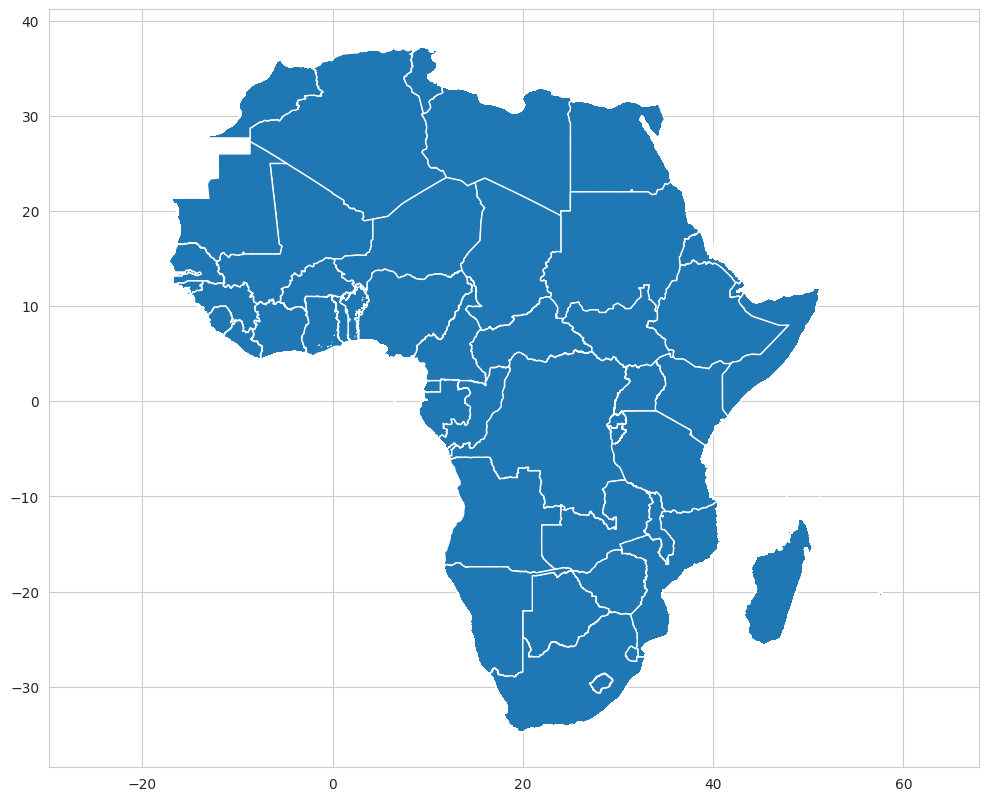

In [62]:
africa.plot(figsize=(12, 12))

In [64]:
## 1. Define EAC countries by ISO3 codes
eac_iso3_codes = [
    'BDI',  # Burundi
    'COD',  # DR Congo
    'KEN',  # Kenya
    'RWA',  # Rwanda
    'SOM',  # Somalia
    'SSD',  # South Sudan
    'UGA',  # Uganda
    'TZA'   # Tanzania
]

## 2. Filter for EAC countries from the African dataset
eac_shapes = africa[africa['GID_0'].isin(eac_iso3_codes)].copy()

<Axes: >

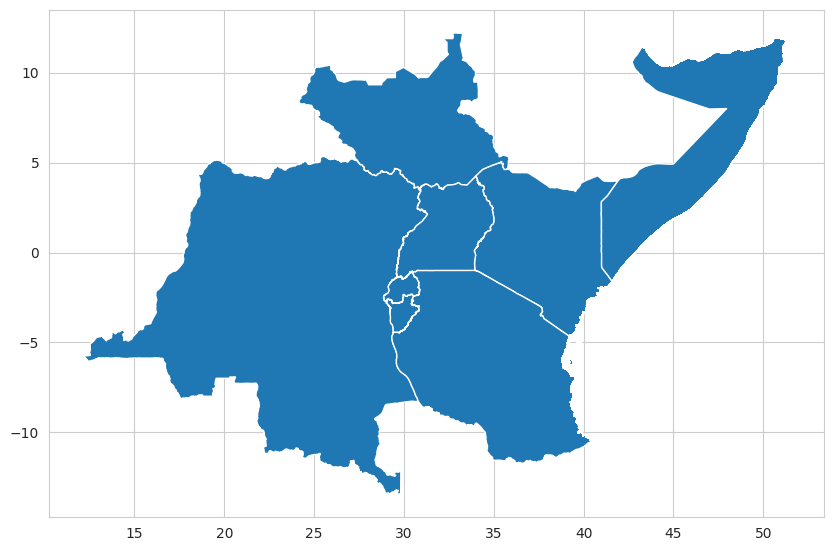

In [65]:
eac_shapes.plot(figsize=(10,10))

### 2.2 Plot Choropleth Maps


In [68]:
print(eac_shapes.columns)
print(latest_neonatal.columns)
print(latest_ufm.columns)

Index(['GID_0', 'COUNTRY', 'geometry'], dtype='object')
Index(['REF_AREA', 'INDICATOR', 'Indicator', 'SEX', 'Sex', 'WEALTH_QUINTILE',
       'Wealth Quintile', 'SERIES_NAME', 'Series Name', 'SERIES_YEAR',
       'Series Year', 'TIME_PERIOD', 'OBS_VALUE', 'OBS_STATUS',
       'Observation Status', 'UNIT_MEASURE', 'Unit of measure', 'REF_DATE',
       'INTERVAL', 'LOWER_BOUND', 'UPPER_BOUND'],
      dtype='object')
Index(['REF_AREA', 'INDICATOR', 'Indicator', 'SEX', 'Sex', 'WEALTH_QUINTILE',
       'Wealth Quintile', 'SERIES_NAME', 'Series Name', 'SERIES_YEAR',
       'Series Year', 'TIME_PERIOD', 'OBS_VALUE', 'OBS_STATUS',
       'Observation Status', 'UNIT_MEASURE', 'Unit of measure', 'REF_DATE',
       'INTERVAL', 'LOWER_BOUND', 'UPPER_BOUND'],
      dtype='object')


In [77]:
# Create a mapping of country names to ISO codes
country_to_iso = {
    'Burundi': 'BDI',
    'Democratic Republic of the Congo': 'COD',
    'Kenya': 'KEN',
    'Rwanda': 'RWA',
    'Somalia': 'SOM',
    'South Sudan': 'SSD',
    'Uganda': 'UGA',
    'Tanzania': 'TZA'
}

# Create a new column in latest_neonatal and latest_ufm for ISO codes
latest_neonatal['ISO_Code'] = latest_neonatal['REF_AREA'].map(country_to_iso)
latest_ufm['ISO_Code'] = latest_ufm['REF_AREA'].map(country_to_iso)

# Merge mortality data with shapes using ISO codes
eac_shapes_neonatal = eac_shapes.merge(
    latest_neonatal, left_on='GID_0', right_on='ISO_Code', how='left'
)
eac_shapes_ufm = eac_shapes.merge(
    latest_ufm, left_on='GID_0', right_on='ISO_Code', how='left'
)

# Create a new figure for the mortality plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot neonatal mortality
eac_shapes_neonatal.plot(
    column='OBS_VALUE', 
    cmap='OrRd', 
    legend=True,
    ax=ax1,
    edgecolor='black',
    linewidth=0.5
)
ax1.set_title("Neonatal Mortality Rate (per 1,000 live births)", fontsize=14)

# Add country labels for neonatal mortality
for x, y, label in zip(eac_shapes_neonatal.geometry.centroid.x, 
                       eac_shapes_neonatal.geometry.centroid.y, 
                       eac_shapes_neonatal['COUNTRY']):
    ax1.text(x, y, label, fontsize=10, ha='center')

# Plot under-5 mortality
eac_shapes_ufm.plot(
    column='OBS_VALUE', 
    cmap='OrRd', 
    legend=True,
    ax=ax2,
    edgecolor='black',
    linewidth=0.5
)
ax2.set_title("Under-5 Mortality Rate (per 1,000 live births)", fontsize=14)

# Add country labels for under-5 mortality
for x, y, label in zip(eac_shapes_ufm.geometry.centroid.x, 
                       eac_shapes_ufm.geometry.centroid.y, 
                       eac_shapes_ufm['COUNTRY']):
    ax2.text(x, y, label, fontsize=10, ha='center')

plt.suptitle("Child Mortality in East African Community (Latest Estimates)", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

/tmp/ipykernel_7747/343001133.py:40: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/tmp/ipykernel_7747/343001133.py:41: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/tmp/ipykernel_7747/343001133.py:57: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/tmp/ipykernel_7747/343001133.py:58: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/tmp/ipykernel_7747/343001133.py:63: UserWarning:

Tight layout not applied. The left and right margins 

## Step 3: Temporal Trends Analysis

### 3.1 Plot Average Trends with Country-Level Points


/tmp/ipykernel_7747/764245314.py:5: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/tmp/ipykernel_7747/764245314.py:15: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

/tmp/ipykernel_7747/764245314.py:29: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/tmp/ipykernel_7747/764245314.py:39: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



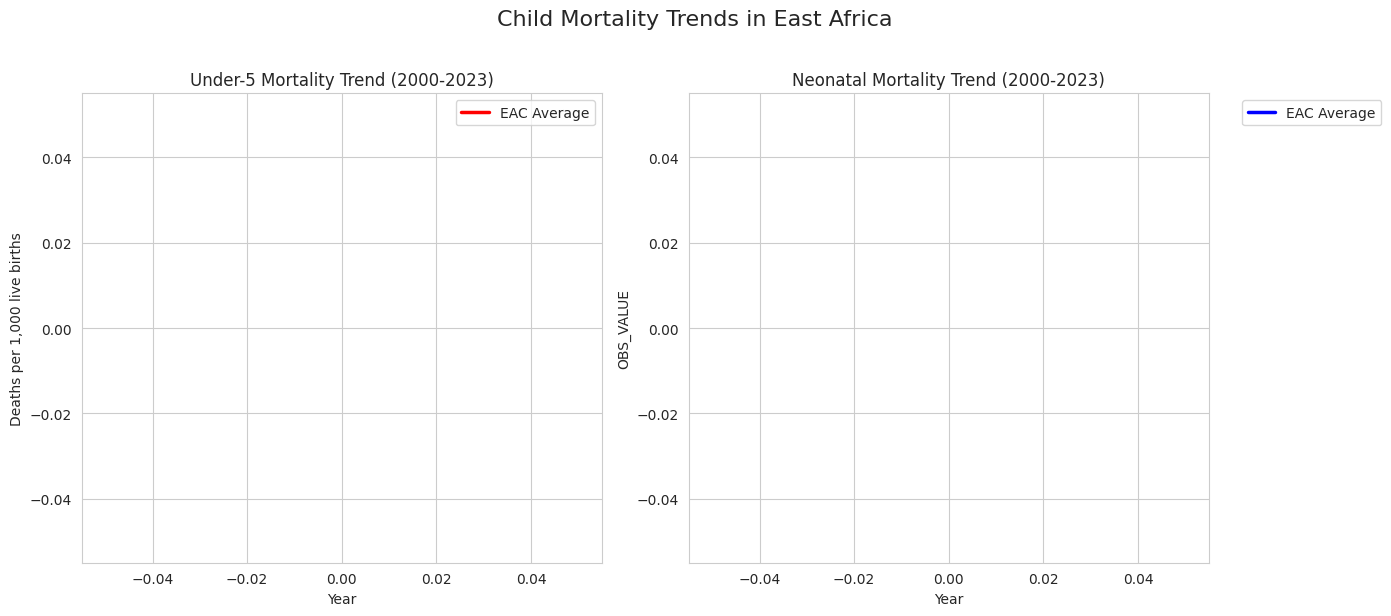

In [70]:
plt.figure(figsize=(14, 6))

# Under-5 mortality trend
plt.subplot(1, 2, 1)
sns.lineplot(
    data=ufm_eac, 
    x='SERIES_YEAR', 
    y='OBS_VALUE', 
    estimator='mean',
    ci=None,
    color='red',
    label='EAC Average',
    linewidth=2.5
)
sns.scatterplot(
    data=ufm_eac,
    x='SERIES_YEAR',
    y='OBS_VALUE',
    hue='Geographic area',
    palette='tab10',
    alpha=0.7
)
plt.title("Under-5 Mortality Trend (2000-2023)")
plt.xlabel("Year")
plt.ylabel("Deaths per 1,000 live births")

# Neonatal mortality trend
plt.subplot(1, 2, 2)
sns.lineplot(
    data=neonatal_eac, 
    x='SERIES_YEAR', 
    y='OBS_VALUE', 
    estimator='mean',
    ci=None,
    color='blue',
    label='EAC Average',
    linewidth=2.5
)
sns.scatterplot(
    data=neonatal_eac,
    x='SERIES_YEAR',
    y='OBS_VALUE',
    hue='Geographic area',
    palette='tab10',
    alpha=0.7
)
plt.title("Neonatal Mortality Trend (2000-2023)")
plt.xlabel("Year")

plt.suptitle("Child Mortality Trends in East Africa", y=1.02, fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Step 4: Identify Highest Mortality Countries

### 4.1 Latest Rankings


In [71]:
print("Under-5 Mortality Ranking (2023):")
print(latest_ufm['OBS_VALUE'].sort_values(ascending=False))

print("\nNeonatal Mortality Ranking (2023):")
print(latest_neonatal['OBS_VALUE'].sort_values(ascending=False))

Under-5 Mortality Ranking (2023):
Series([], Name: OBS_VALUE, dtype: float64)

Neonatal Mortality Ranking (2023):
Series([], Name: OBS_VALUE, dtype: float64)


## 4.2 Creative Visualization: Mortality Divergence


In [ ]:
# Calculate improvement since 2000
ufm_improvement = ufm_eac.groupby('Geographic area').apply(
    lambda x: x[x['SERIES_YEAR'] == 2000]['OBS_VALUE'].values[0] - 
    x[x['SERIES_YEAR'] == 2023]['OBS_VALUE'].values[0]
)

plt.figure(figsize=(10, 6))
ufm_improvement.sort_values().plot(kind='barh', color='teal',axis=1)
plt.title("Reduction in Under-5 Mortality (2000-2023)")
plt.xlabel("Deaths per 1,000 live births avoided")
plt.grid(axis='x', linestyle='--')
plt.show()

/tmp/ipykernel_7747/784889980.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

<Figure size 1000x600 with 0 Axes>